In [1]:
# Cell 1: Install specialized tools
!pip install -q transformers[torch] datasets pandas scikit-learn seaborn matplotlib umap-learn bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.9 MB/s eta 0:00:00


In [3]:
# Step 1 - Classification/Mapping of Emotions Present into Navarasa & Bhakti Rasa
import pandas as pd

# 1. Load the dataset
df = pd.read_csv('pri_emo.csv')

# 2. Comprehensive Indian Aesthetic Mapping
# Maps human emotions (Navarasa) and spiritual states (Bhakti)
rasa_mapping = {
    # Bhakti
    'Reverence': 'Bhakti', 'Devotion': 'Bhakti', 'Gratitude': 'Bhakti',
    'Respect': 'Bhakti', 'Generosity': 'Bhakti', 'Hospitality': 'Bhakti',
    'Commitment': 'Bhakti',

    # Shringara
    'Love': 'Shringara', 'Longing': 'Shringara',

    # Hasya
    'Joy': 'Hasya', 'Happiness': 'Hasya',

    # Karuna
    'Sorrow': 'Karuna', 'Sadness': 'Karuna', 'Melancholy': 'Karuna',
    'Despair': 'Karuna', 'Compassion': 'Karuna', 'Kindness': 'Karuna',

    # Raudra
    'Anger': 'Raudra', 'Complaint': 'Raudra',

    # Veera
    'Courage': 'Veera', 'Pride': 'Veera', 'Confidence': 'Veera',
    'Patriotism': 'Veera', 'Duty': 'Veera', 'Responsibility': 'Veera',
    'Loyalty': 'Veera',

    # Bhayankara
    'Fear': 'Bhayanaka', 'Caution': 'Bhayanaka',

    # Bibhatsa
    'Shame': 'Bibhatsa', 'Betrayal': 'Bibhatsa',

    # Adbhuta
    'Skill': 'Adbhuta', 'Wisdom': 'Adbhuta', 'Clarity': 'Adbhuta',

    # Shanta
    'Calmness': 'Shanta', 'Contentment': 'Shanta', 'Patience': 'Shanta',
    'Integrity': 'Shanta', 'Modesty': 'Shanta', 'Humility': 'Shanta',
    'Self-Control': 'Shanta', 'Honesty': 'Shanta', 'Security': 'Shanta',
    'Philosophy': 'Shanta', 'Nature': 'Shanta'
}

# 3. Apply the Mapping
df['Primary'] = df['Primary'].astype(str).str.strip()
df['Rasa_Category'] = df['Primary'].map(rasa_mapping).fillna('Mixed/Other')

# 4. Detailed Summary Generation
print("--- Frequency of Emotional Categories (Rasas) ---")
rasa_counts = df['Rasa_Category'].value_counts()
print(rasa_counts)

print("\n--- Top 10 Specific Emotions within the Data ---")
print(df['Primary'].value_counts().head(10))

def assign_contextual_cue(emotion):
    # Morality Cues
    if emotion in ['Duty', 'Integrity', 'Honesty', 'Modesty', 'Humility', 'Responsibility', 'Integrity']:
        return 'Morality'
    # Devotion Cues
    elif emotion in ['Reverence', 'Devotion', 'Gratitude', 'Respect', 'Commitment']:
        return 'Devotion'
    # Nature Cues
    elif emotion in ['Nature', 'Calmness', 'Patience']:
        return 'Nature'
    # Default
    return 'Philosophical/General'

df['Contextual_Cues'] = df['Primary'].apply(assign_contextual_cue)
# 5. Save the classified data to a new file
df.to_csv('classified_emotions.csv', index=False)
print("\nSuccess: Classified data saved to 'classified_emotions.csv'")

--- Frequency of Emotional Categories (Rasas) ---
Rasa_Category
Karuna         1212
Shringara      1021
Shanta          426
Veera           357
Bhayanaka       259
Hasya           254
Bhakti          223
Raudra          116
Bibhatsa         90
Mixed/Other      86
Adbhuta          80
Name: count, dtype: int64

--- Top 10 Specific Emotions within the Data ---
Primary
Longing       719
Melancholy    555
Sadness       543
Love          302
Happiness     200
Philosophy    159
Caution       140
Fear          119
Patriotism    117
Nature        107
Name: count, dtype: int64

Success: Classified data saved to 'classified_emotions.csv'


In [4]:
# Transformer pre-req
df['model_input'] = "Context: " + df['Contextual_Cues'] + " | Verse: " + df['Poem']

In [5]:
from transformers import AutoTokenizer
from datasets import Dataset
import torch

# Calling MuRIL Tokenizer
model_name = "google/muril-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Define the Tokenization Function
def tokenize_function(examples):
    # padding="max_length" ensures all inputs are the same size for the GPU
    # truncation=True prevents errors if a poem is unusually long
    return tokenizer(examples["model_input"], padding="max_length", truncation=True, max_length=128)

# 3. Convert Pandas DataFrame to HuggingFace Dataset Object
# This format is mandatory for the high-speed 'Trainer' API
hf_dataset = Dataset.from_pandas(df)

# 4. Map the tokenization across the dataset
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

# 5. Prepare the final split for the model
# We split 80% for training and 20% for testing (validation)
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

print("Tokenization Complete!")
print(f"Training samples: {len(tokenized_datasets['train'])}")
print(f"Validation samples: {len(tokenized_datasets['test'])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

Map:   0%|          | 0/4124 [00:00<?, ? examples/s]

Tokenization Complete!
Training samples: 3299
Validation samples: 825


In [15]:
# Rename the target column to 'labels' so the model can calculate Loss
tokenized_datasets = tokenized_datasets.map(lambda x: {"labels": x["Rasa_Category"]}, batched=True)

# Important: Convert the text labels to numerical IDs for the model
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['Rasa_Category'])

# Re-map the IDs to the tokenized dataset
def map_label_ids(example):
    return {"labels": le.transform([example["Rasa_Category"]])[0]}

tokenized_datasets = tokenized_datasets.map(map_label_ids)

# Set format for PyTorch
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("Dataset fixed. Columns now include:", tokenized_datasets["train"].column_names)

Map:   0%|          | 0/3299 [00:00<?, ? examples/s]

Map:   0%|          | 0/825 [00:00<?, ? examples/s]

Map:   0%|          | 0/3299 [00:00<?, ? examples/s]

Map:   0%|          | 0/825 [00:00<?, ? examples/s]

Dataset fixed. Columns now include: ['Sl.No.', 'Poem', 'Source', 'Primary', 'Rasa_Category', 'Contextual_Cues', 'model_input', 'input_ids', 'token_type_ids', 'attention_mask', 'labels']


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: google/muril-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expe

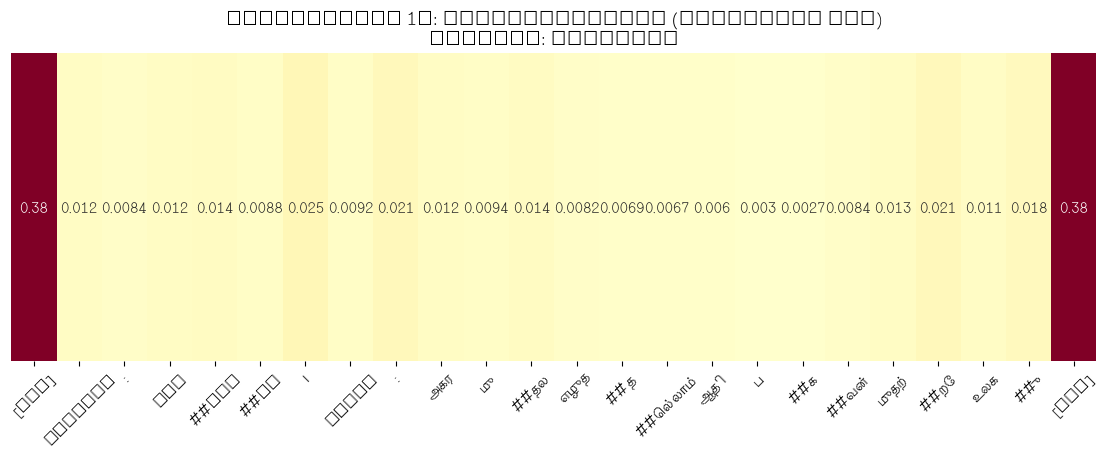

Starting Weighted Training...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [62]:
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Class Weight Calculation
# Gives value to all emotions equally so the model doesn't become lazy in itself
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_id']),
    y=df['label_id']
)
# Convert weights to a PyTorch tensor for the GPU
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda")

# 2. Custom Weight -> To increase efficiency, we define a loss factor & appropriate
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Apply the weights to the CrossEntropyLoss
        loss_fct = nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

from transformers import AutoModelForSequenceClassification, AutoConfig

# 1. Re-initialize Config with attention output enabled
config = AutoConfig.from_pretrained(
    "google/muril-base-cased",
    num_labels=len(le.classes_),
    output_attentions=True,  # Critical for Deliverable 1e
    id2label={i: label for i, label in enumerate(le.classes_)},
    label2id={label: i for i, label in enumerate(le.classes_)}
)

# 2. Re-load model and explicitly send to CUDA
model = AutoModelForSequenceClassification.from_pretrained(
    "google/muril-base-cased",
    config=config
).to("cuda") # Ensure all internal tensors move to GPU

# 3. Update the Heatmap function to handle tensor device matching
def generate_attention_heatmap(verse, context_cue="Devotion"):
    model.eval()

    # Ensure inputs are moved to the same device as the model
    inputs = tokenizer(f"Context: {context_cue} | Verse: {verse}",
                       return_tensors="pt",
                       truncation=True,
                       padding=True).to(model.device) # Dynamic device matching

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    if outputs.attentions is None:
        print("Error: Attentions not found. Ensure output_attentions=True in config.")
        return

    # Extract attention weights
    last_layer_attention = outputs.attentions[-1][0].mean(dim=0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    cls_attention = last_layer_attention[0, :len(tokens)]

    # Plot
    plt.figure(figsize=(14, 4))
    sns.heatmap([cls_attention], xticklabels=tokens, yticklabels=False,
                cmap="YlOrRd", annot=True, cbar=False)
    plt.title(f"Deliverable 1e: Explainability (Attention Map)\nContext: {context_cue}")
    plt.xticks(rotation=45)
    plt.show()

# Run the fix
generate_attention_heatmap("அகர முதல எழுத்தெல்லாம் ஆதி பகவன் முதற்றே உலகு", context_cue="Devotion")

# 4. Training
# slight buff in training & weight decay
training_args = TrainingArguments(
    output_dir="./rasa_optimized_model",
    num_train_epochs=5,              # increase in epochs to provide more surface area
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,              # Slightly higher for better convergence with weights
    weight_decay=0.02,               # Stronger regularization
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro", # Switching to Macro F1 ensures we optimize for ALL Rasas equally
    report_to="none"
)

# 5. Initialize New Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics, # Uses your existing metrics function
)

# 6. Execute Boosted Training
print("Starting Weighted Training...")
trainer.train()

In [18]:
from transformers import get_linear_schedule_with_warmup, EarlyStoppingCallback

# 1. Update Arguments for higher precision
training_args = TrainingArguments(
    output_dir="./rasa_optimized_v2",
    num_train_epochs=7,               # Increased epochs for deeper learning
    per_device_train_batch_size=8,    # Smaller batch size for better "attention" to detail
    gradient_accumulation_steps=2,    # Effectively keeps batch size at 16 but processes more carefully
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,               # Slower, more precise learning rate
    weight_decay=0.05,                # Higher decay to prevent overfitting
    warmup_steps=100,                 # Linear warmup for stability
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)

# 2. Re-initialize the Weighted Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Stops if model plateaus
)

print("Starting Precision Fine-Tuning...")
trainer.train()

Starting Precision Fine-Tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,No log,1.932561,0.380606,0.326215,0.230437
2,No log,1.938873,0.374545,0.333307,0.254421
3,3.486169,1.921779,0.383030,0.345005,0.257835
4,3.486169,1.891071,0.398788,0.344881,0.254308
5,3.130249,1.914191,0.392727,0.349886,0.259200
6,3.130249,1.934723,0.398788,0.349222,0.257084
7,3.130249,1.912464,0.403636,0.356417,0.263407


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=1449, training_loss=3.1838033503709453, metrics={'train_runtime': 1015.9384, 'train_samples_per_second': 22.731, 'train_steps_per_second': 1.426, 'total_flos': 1519128647226624.0, 'train_loss': 3.1838033503709453, 'epoch': 7.0})

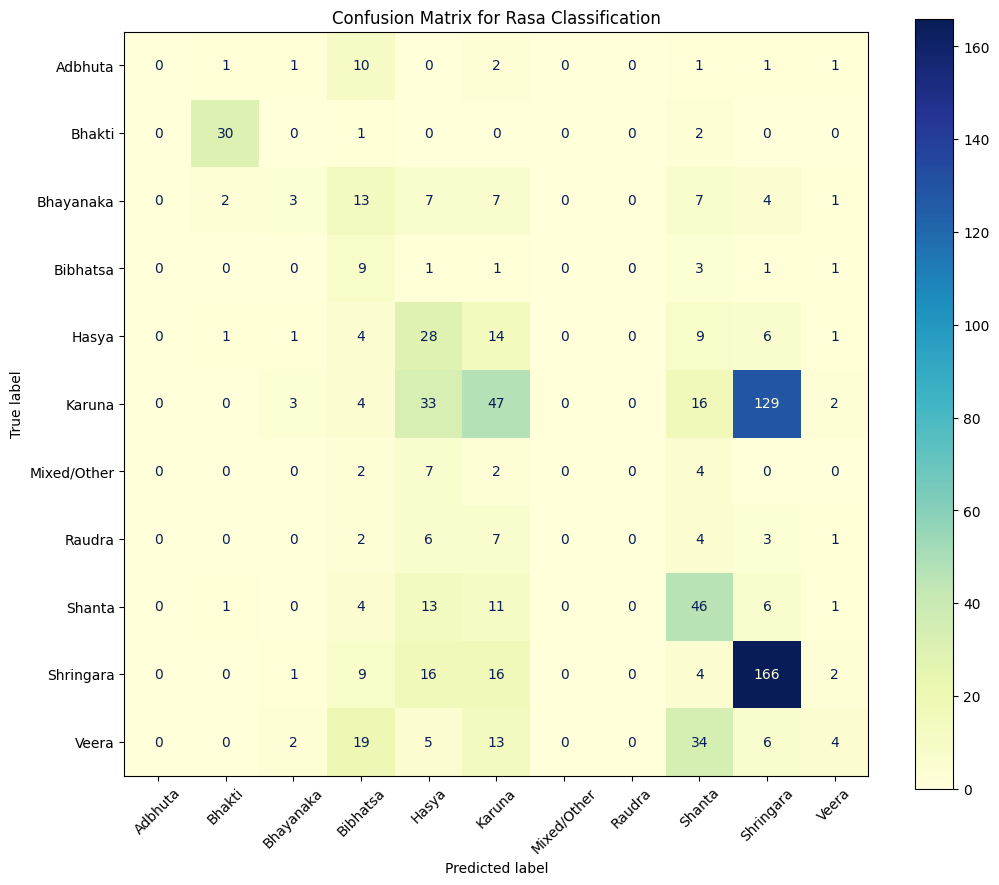

In [21]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on the test set
predictions = trainer.predict(tokenized_datasets["test"])
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = tokenized_datasets["test"]["labels"]

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='YlGnBu', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix for Rasa Classification")
plt.show()

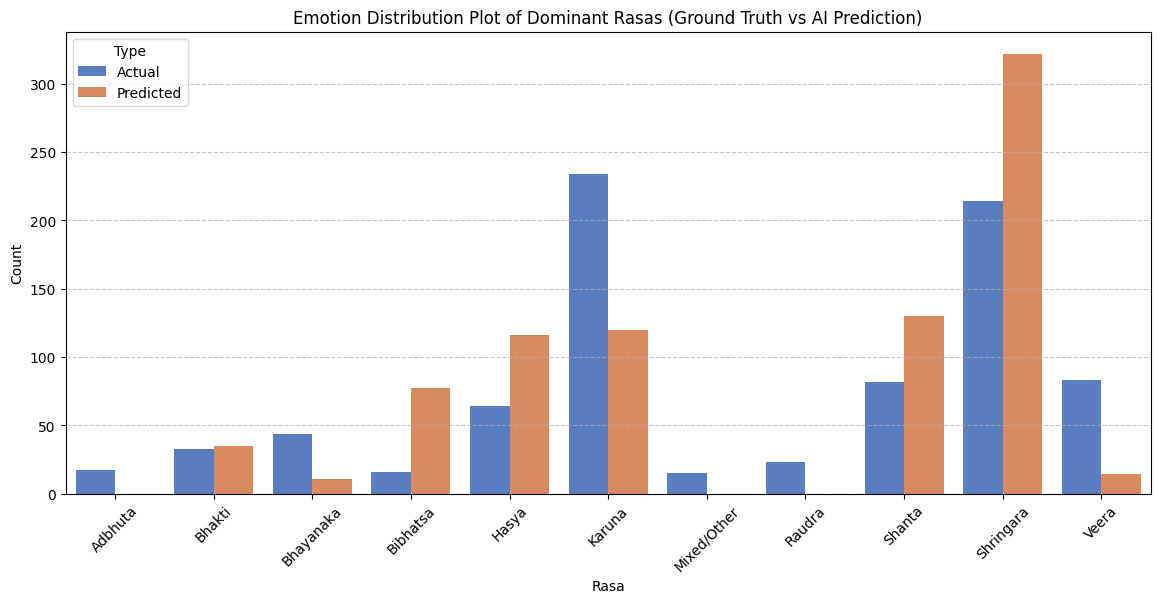

In [23]:
import seaborn as sns
import pandas as pd

# Create a summary dataframe
dist_df = pd.DataFrame({
    'Rasa': list(le.classes_) * 2,
    'Count': list(np.bincount(y_true, minlength=len(le.classes_))) + list(np.bincount(y_pred, minlength=len(le.classes_))),
    'Type': ['Actual'] * len(le.classes_) + ['Predicted'] * len(le.classes_)
})

plt.figure(figsize=(14, 6))
sns.barplot(data=dist_df, x='Rasa', y='Count', hue='Type', palette='muted')
plt.title("Emotion Distribution Plot of Dominant Rasas (Ground Truth vs AI Prediction)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
import torch

def verse_emotion_mapping_interface(verse):
    # Additional Keywords Added
    context_keywords = {
        "Devotion/Spirituality": ["பகவன்", "ஆதி", "Lord", "God", "Divine", "sharanam", "prayer"],
        "Morality/Ethics/Philosophy": ["அறம்", "Virtue", "Duty", "Dharma", "Righteous", "Moral"],
        "Nature/Symbolism": ["மலர", "Flower", "River", "Sun", "Mountain", "Ganges", "Season"]
    }

    # Rule Based Logic for Context Cue Detection
    associated_cue = "General Philosophical" # Default category
    for cue, keywords in context_keywords.items():
        if any(word.lower() in verse.lower() for word in keywords):
            associated_cue = cue
            break

    # Dominant Emotion Prediction
    model_input = f"Context: {associated_cue} | Verse: {verse}"

    inputs = tokenizer(model_input, return_tensors="pt", truncation=True, padding=True).to("cuda")

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = torch.max(probs).item()

    predicted_emotion = le.classes_[pred_idx]

    # Final Output
    print(f"\n{'='*70}")
    print(f" (a) INPUT VERSE          : {verse}")
    print(f" (b) PREDICTED EMOTION    : {predicted_emotion.upper()} (Navarasa)")
    print(f" (c) ASSOCIATED CUES      : {associated_cue}")
    print(f"{'-'*70}")
    print(f" MODEL CONFIDENCE SCORE    : {confidence:.2%}")
    print(f"{'='*70}")

# Test Case
print("Testing Deliverable 1c Interface...")
verse_emotion_mapping_interface("அகர முதல எழுத்தெல்லாம் ஆதி பகவன் முதற்றே உலகு")

Testing Deliverable 1c Interface...

 (a) INPUT VERSE          : அகர முதல எழுத்தெல்லாம் ஆதி பகவன் முதற்றே உலகு
 (b) PREDICTED EMOTION    : BHAKTI (Navarasa)
 (c) ASSOCIATED CUES      : Devotion/Spirituality
----------------------------------------------------------------------
 MODEL CONFIDENCE SCORE    : 64.83%


Extracting model embeddings for visualization...


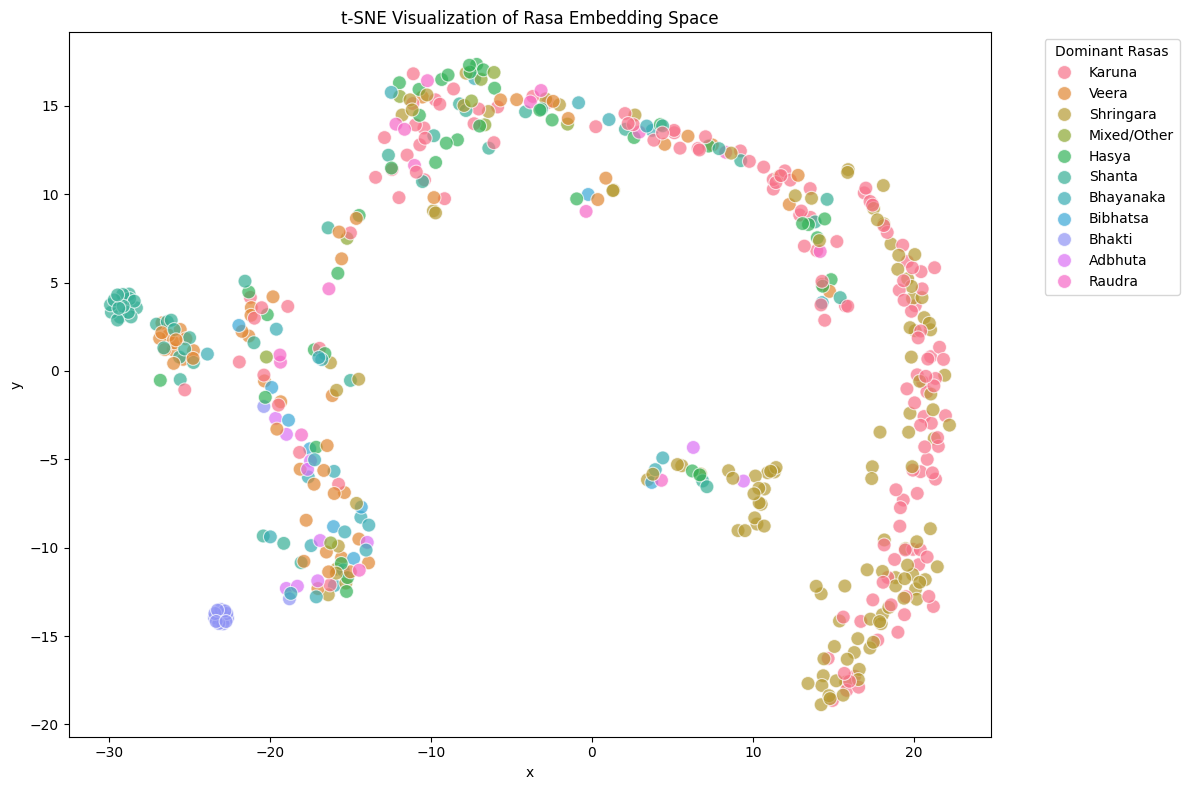

In [44]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_embedding_space():
    model.eval()
    all_embeddings = []
    all_labels = []

    print("Extracting model embeddings for visualization...")
    subset_size = min(500, len(tokenized_datasets["test"]))

    # Identify the base model (e.g., model.bert)
    base_model = getattr(model, model.config.model_type)

    for i in range(subset_size):
        item = tokenized_datasets["test"][i]

        # FIX: Check if items are already tensors; if not, convert them.
        # Then ensure they have a batch dimension (unsqueeze(0))
        def prepare_tensor(data):
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data)
            return data.unsqueeze(0).to("cuda")

        inputs = {
            'input_ids': prepare_tensor(item['input_ids']),
            'attention_mask': prepare_tensor(item['attention_mask'])
        }

        if 'token_type_ids' in item:
            inputs['token_type_ids'] = prepare_tensor(item['token_type_ids'])

        with torch.no_grad():
            outputs = base_model(**inputs)
            # Use [CLS] token embedding for the entire verse representation
            embeddings = outputs.last_hidden_state[0][0].cpu().numpy()

        all_embeddings.append(embeddings)
        all_labels.append(le.classes_[item['labels']])

    # Dimension reduction
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    vis_dims = tsne.fit_transform(np.array(all_embeddings))

    df = pd.DataFrame({
        'x': vis_dims[:, 0],
        'y': vis_dims[:, 1],
        'Rasa': all_labels
    })

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='Rasa', palette='husl', s=100, alpha=0.7)
    plt.title("t-SNE Visualization of Rasa Embedding Space")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Dominant Rasas")
    plt.tight_layout()
    plt.show()

plot_embedding_space()